# **[exercise 3]** Energy System Optimization
In this notebook we are going to design a system for a family house depending on their demand structure that would optimise their expenses for energy. 

Furthermore we will cover the following topics:
- [x] Optimization

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
!conda install -c conda-forge glpk -y

Channels:
 - conda-forge
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 24.3.0
    latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [3]:
%run installation.py ;

### Task 1.1 : Basic imports <a class="anchor" id="#task-11--identify-the-maximum-electrical-demand"></a>

**Task description:** Import the most basic python packages such as ``numpy``,``pandas``, ``matplotlib`` and ``json``. Use meaningful abbreviations to shorten a method call, e.g. ``import package as pgk``.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

After intensive expert consultation, Family Potter has decided to invest in a brine-water heat-pump for their single family home (see Exercise 2). The heating expert recommended to also consult an electrical specialist, as a photovoltaic (PV) system in combination with the heat pump as shown in Figure 1 might be beneficial.
Help family Potter regarding their investment decision.

![Single family house](../../datasets/mes/exercise_3/figures/sfh_building_energy_system.png "Single Family House")

Figure 1: Building energy system of the single family home with a brine-water heat-pump, a PV system and a battery storage

## A) Demand structure
In the present case, the scope of consideration comprises the heat demand (room heating and warm-water), as well as the electricity demand (lighting, cooking, etc.). The whole heat demand of the building is covered by the heat pump system.

For the moment, we have no demand series profiles given for the heat nor the electricity demand. We need to make useful assumptions, depending on standard load profiles from the literature. In exercise 2, we already used the standard load profiles for electricity. Now it is our turn to use the heat profile from a research work, that analyzed the heat demand for Germany. Let us inspect the data first:

In [5]:
# Define the file path
import pathlib
parent_folder = pathlib.Path.cwd().parents[1] / "datasets" / "mes" / "exercise_3" / "data"
file_path = parent_folder / "when2heat_germany.xlsx"

# Read in load profiles
when2heat = pd.read_excel(file_path, index_col=[0], parse_dates=True, header=[0, 1, 2, 3])
when2heat

country                            DE                                         
variable                          COP                                         
attribute                  ASHP_floor ASHP_radiator  ASHP_water  GSHP_floor   
unit                      coefficient   coefficient coefficient coefficient   
2007-12-31 22:00:00+00:00        2.62          3.13        2.23        2.94  \
2007-12-31 23:00:00+00:00        2.62          3.13        2.23        2.94   
2008-01-01 00:00:00+00:00        2.61          3.12        2.22        2.92   
2008-01-01 01:00:00+00:00        2.61          3.11        2.22        2.90   
2008-01-01 02:00:00+00:00        2.60          3.11        2.22        2.88   
...                               ...           ...         ...         ...   
2020-12-31 19:00:00+00:00        2.75          3.24        2.28        3.10   
2020-12-31 20:00:00+00:00        2.74          3.23        2.27        3.08   
2020-12-31 21:00:00+00:00        2.73          3.22        2.27        3.09   
2020-12-31 22:00:00+00:00        2.72          3.21        2.27        3.07   
2020-12-31 23:00:00+00:00        2.72          3.21        2.27        3.07   

country                                                                         
variable                                                                        
attribute                 GSHP_radiator  GSHP_water  WSHP_floor WSHP_radiator   
unit                        coefficient coefficient coefficient   coefficient   
2007-12-31 22:00:00+00:00          3.94        2.19        3.60          4.74  \
2007-12-31 23:00:00+00:00          3.94        2.19        3.60          4.74   
2008-01-01 00:00:00+00:00          3.92        2.18        3.59          4.74   
2008-01-01 01:00:00+00:00          3.90        2.17        3.58          4.73   
2008-01-01 02:00:00+00:00          3.88        2.16        3.57          4.72   
...                                 ...         ...         ...           ...   
2020-12-31 19:00:00+00:00          4.06        2.22        3.74          4.83   
2020-12-31 20:00:00+00:00          4.04        2.21        3.73          4.82   
2020-12-31 21:00:00+00:00          4.05        2.22        3.72          4.81   
2020-12-31 22:00:00+00:00          4.04        2.22        3.71          4.81   
2020-12-31 23:00:00+00:00          4.04        2.22        3.71          4.81   

country                                            ...                     
variable                              heat_demand  ...                     
attribute                  WSHP_water       space  ...   water water_COM   
unit                      coefficient          MW  ...      MW        MW   
2007-12-31 22:00:00+00:00         2.7     91867.0  ...  3429.0    1690.0  \
2007-12-31 23:00:00+00:00         2.7     91867.0  ...  3429.0    1690.0   
2008-01-01 00:00:00+00:00         2.7     94072.0  ...  4015.0    2127.0   
2008-01-01 01:00:00+00:00         2.7     96511.0  ...  3944.0    2211.0   
2008-01-01 02:00:00+00:00         2.7    102811.0  ...  4372.0    2260.0   
...                               ...         ...  ...     ...       ...   
2020-12-31 19:00:00+00:00         2.7         NaN  ...     NaN       NaN   
2020-12-31 20:00:00+00:00         2.7         NaN  ...     NaN       NaN   
2020-12-31 21:00:00+00:00         2.7         NaN  ...     NaN       NaN   
2020-12-31 22:00:00+00:00         2.7         NaN  ...     NaN       NaN   
2020-12-31 23:00:00+00:00         2.7         NaN  ...     NaN       NaN   

country                                                                
variable                                      heat_profile             
attribute                 water_MFH water_SFH    space_COM space_MFH   
unit                             MW        MW       MW/TWh    MW/TWh   
2007-12-31 22:00:00+00:00    1218.0     521.0        218.0     152.0  \
2007-12-31 23:00:00+00:00    1218.0     521.0        218.0     152.0   
2008-01-01 00:00:00+00:00

What we see here is a multi-index pandas dataframe, observe for example that there are multiple headers used. The first header describes the country of observation. The original data frame consisted of all European countries, but we have already reduced the size to Germany. In the second header, we have the variable of observation, the third header displays the attribute given and the last one is indicating the unit. For us, the heat profile is of great interest. However, the scaling is not useful to us, thereby we would like to normalize the data. 

### Task 2.1 : Min-Max-Normalization <a class="anchor" id="#task-31--min-max-normalization"></a>

We apply the Min-Max-Normalization to the original unscaled data.

$$ x' = \frac{x-x_{min}}{x_{max}-x_{min}} \qquad x' \in [0,1] $$

where $x$ is the original value and $x'$ is the rescaled value.

**Task description:** Perform the min-max-normalization on the warm-water and space heating demand. Furthermore multiply the normalized data with the peak demand for warm water, which is $\hat{p}_{ww}=3.5 kW$ and the heat demand, which is $\hat{p}_{sh}=14.5 kW$.

In [6]:
# Set up the time index
start_date = '2021-01-01 00:00'
end_date = '2021-12-31 23:00'
hourly_index = pd.date_range(start=start_date, end=end_date, freq='H')

# Generate warm-water demand profile
warm_water_demand_de = when2heat[("DE", "heat_profile", "water_SFH", "MW/TWh")]["2019"].to_numpy()
norm_warm_water_demand_de = (warm_water_demand_de - min(warm_water_demand_de)) / (max(warm_water_demand_de) - min(warm_water_demand_de))
peak_warm_water_demand = 3.5
warm_water_demand = norm_warm_water_demand_de * peak_warm_water_demand

# Generate room heating demand profile
heating_demand_de = when2heat[("DE", "heat_profile", "space_SFH", "MW/TWh")]["2019"].to_numpy()
norm_heating_demand_de = (heating_demand_de - min(heating_demand_de)) / (max(heating_demand_de) - min(heating_demand_de))
peak_heating_demand = 14.5
heating_demand = norm_heating_demand_de * peak_heating_demand

# Generate electricity demand profile
import demandlib.bdew as bdew
e_slp = bdew.ElecSlp(2019)
elec_demand = e_slp.get_profile(ann_el_demand_per_sector= {"h0_dyn": 5047}).resample("H").mean()
electricity_demand = elec_demand["h0_dyn"].to_numpy()

# Combine demand profiles into a single dataframe
df = pd.DataFrame({'Warm-water demand (kWh)': warm_water_demand,
                   'Room heating demand (kWh)': heating_demand,
                   'Electricity demand (kWh)': electricity_demand},
                  index=hourly_index)

# Aggregate to yearly demand
yearly_demand = df.resample('Y').sum()

print(df)

                     Warm-water demand (kWh)  Room heating demand (kWh)   
2021-01-01 00:00:00                 0.069444                   3.368363  \
2021-01-01 01:00:00                 0.027778                   3.496681   
2021-01-01 02:00:00                 0.180556                   3.881637   
2021-01-01 03:00:00                 0.597222                   4.747788   
2021-01-01 04:00:00                 2.194444                   6.383850   
...                                      ...                        ...   
2021-12-31 19:00:00                 1.902778                   9.046460   
2021-12-31 20:00:00                 1.611111                   8.051991   
2021-12-31 21:00:00                 0.875000                   5.998894   
2021-12-31 22:00:00                 0.277778                   5.068584   
2021-12-31 23:00:00                 0.027778                   6.063053   

                     Electricity demand (kWh)  
2021-01-01 00:00:00                  0.365542  
202

We can now observe, if we found a reasonable demand structure, for now, a visual inspection is sufficient, check the units and describe 
1. Why you think this is correct?
2. Would you have expected the same?
3. Does the data follow a specific pattern?

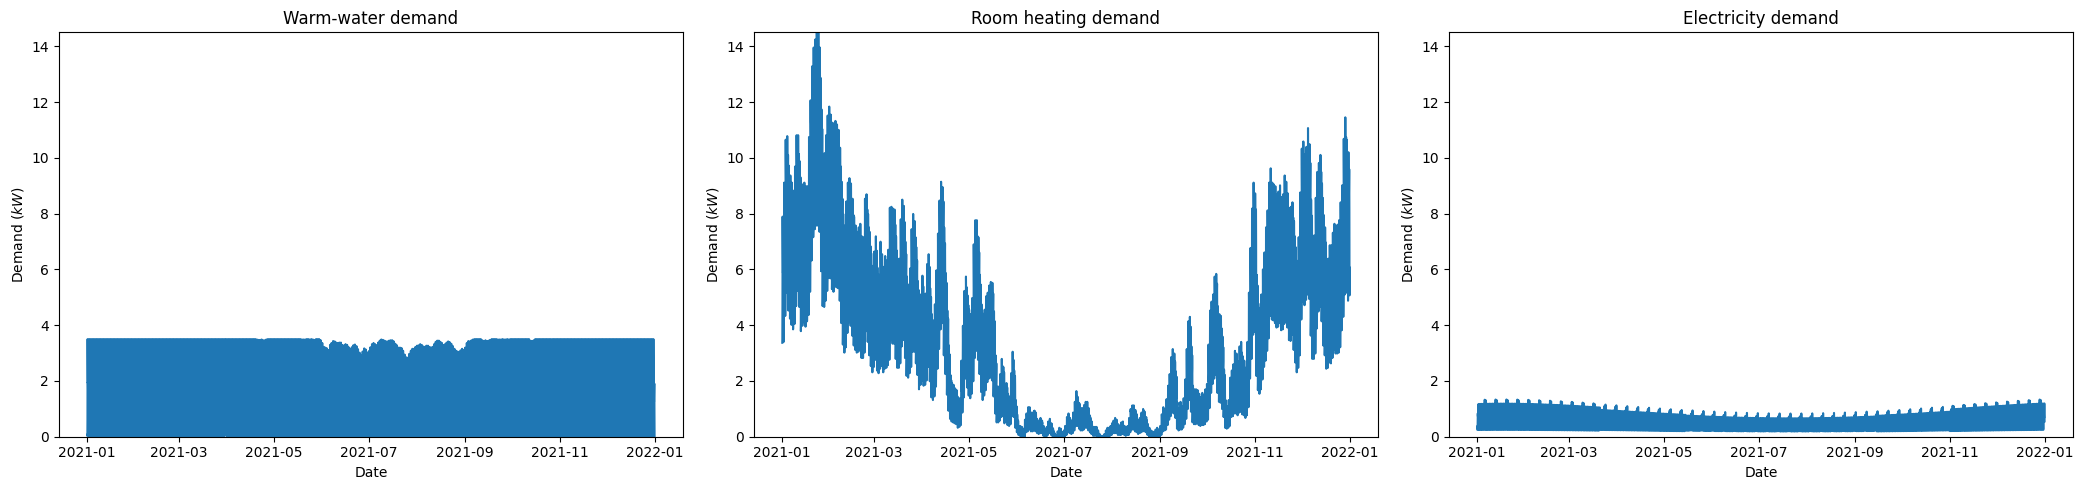

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(21, 5))

max_y_lim = df.max().max()

for i, j in enumerate(['Warm-water', 'Room heating', 'Electricity']):
    axs[i].plot(df[f'{j} demand (kWh)'])
    axs[i].set_title(f'{j} demand')

for i in range(3):
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Demand ($kW$)')
    axs[i].set_ylim(0, max_y_lim)

plt.tight_layout()
plt.show()

For dimensioning the PV-battery combination, the planner needs to determine the total electricity demand in order to find the optimal level of self-sufficiency for the energy system of the building. The warm-water provision and the heat input to the space heating circuit are assumed to be at the same temperature level.

## Task 3 : Coefficient of performance <a class="anchor" id="task-1--tsa"></a>
The coefficient of performance (COP) is a measure of efficiency in HVAC and refrigeration systems. It represents the ratio of the desired output (cooling/heating effect) to the required input (energy consumption). The COP is time-dependent because it varies based on factors like temperature, load conditions, and operating conditions. Changes in these factors can affect the system's efficiency and, consequently, the COP.

Cooling | Heating
- | - 
![Cooling](../../datasets/mes/exercise_3/figures/400px-Cooling_cop_picture_2.JPG) | ![Heating](../../datasets/mes/exercise_3/figures/400px-Heating_cop_picture_2.JPG)

### Task 3.1 : Identify the electrical demand with a constant COP <a class="anchor" id="#task-11--identify-the-maximum-electrical-demand"></a>

**Task description:** Calculate the electrical demand of the heat-pump at a constant Coefficient of Performance (COP) of 3.5.

$$ E_{COP,y}^{BHP} = \int_t \frac{Q^{WW}_t + Q^{RH}_t}{COP_y} $$

Store it in a variable called ``e_demand_const_cop``.

In [8]:
q_ww = df["Warm-water demand (kWh)"].sum()
q_rh = df["Room heating demand (kWh)"].sum()
COP = 3.5

e_demand_const_cop = (q_ww+q_rh) / COP
e_demand_const_cop

12706.577679449361

<div class="alert alert-block alert-success">
<b>Solution:</b> The total heat demand with a constant COP is 12706.58 $kWh$.
</div>

### Task 3.2 : Identify the electrical demand with a variable COP <a class="anchor" id="#task-11--identify-the-electrical-demand-variable-cop"></a>

**Task description:** Calculate the electrical demand of the heat-pump at a variable COP with:

$$ E_{COP,t}^{BHP} = \int_t \frac{Q^{WW}_{t} + Q^{RH}_{t}}{COP_{y,t}} $$

<center>

t | 1:2190 | 2191:4380 | 4381:6570 | 6571:8760
--- | --- | --- | --- | ---
COP | 3.5 | 2.0 | 5.0 | 3.5

<center>

Store it in a variable called ``e_demand_var_cop``.

In [9]:
COP_t  = np.repeat(np.array([3.5, 2.0, 5.0, 3.5]), 2190)

e_demand_var_cop = np.sum((df["Warm-water demand (kWh)"] + df["Room heating demand (kWh)"]) / COP_t)

e_demand_var_cop

13994.159183171794

<div class="alert alert-block alert-success">
<b>Solution:</b> The total heat demand with a variable COP is 13994.16 $kWh$.
</div>

**Bonus task description:** Could you use the COP from the above given dataset when2heat?

In [10]:
## Your code goes here

### Task 3.2 : Identify the electrical demand with a variable COP <a class="anchor" id="#task-11--identify-the-maximum-electrical-demand"></a>
**Task description**: What is the ratio between the electrical power of the heat pump and the plain electrical consumption, for a constant and for a variable COP?

$$ \theta = \sum_t \frac{P^{heat}_t}{P^{elec}_t} $$

In [11]:
ratio_const_cop = e_demand_const_cop / electricity_demand.sum()
ration_var_cop = e_demand_var_cop / electricity_demand.sum()

print(ratio_const_cop)
print(ration_var_cop)

2.5176134434586483
2.7727279664322944


<div class="alert alert-block alert-success">
<b>Solution:</b> The ratio for the constant is 2.51 times as high and for the variable it is 2.77 times. 
</div>

___
## B) Solar Yield

Starting on the demand structure, we have computed in the first part the needed electrical demand, given by the heating demand covered by an electric-fuelled heat pump and also the plain electrical demand, e.g. for powering your computer. Next, we would like to cover this electrical demand by the installation of pv system, which is not yet existing. For this reason, we would need an estimate on the pv infeed that can be espected for an installation.

Data on the feed in for a potential PV system can be found via numerous sources or computed, however, for now we are accessing data given by the European Commission ([PVGIS](https://joint-research-centre.ec.europa.eu/pvgis-online-tool_en)).

![Solar yield](../../datasets/mes/exercise_3/figures/solar_yield.png "Solar Yield")

Figure 2: Solar yield for a pv system as calculated by  on an hourly granularity for 2020

Let us therefore first scrape the data, which has been already done and we also need to do data cleansing as the downloaded date was a leap year and we would like to remove this day to be comparable.

In [12]:
parent_folder = pathlib.Path.cwd().parents[1] / "datasets" / "mes" / "exercise_3" / "data"
file_path = parent_folder / "Timeseries_50.763_6.081_SA2_1kWp_crystSi_14_41deg_-2deg_2020_2020.json"
if not file_path.exists():
    parent_folder = pathlib.Path.cwd() / "data"
    file_path = parent_folder / "Timeseries_50.763_6.081_SA2_1kWp_crystSi_14_41deg_-2deg_2020_2020.json"

import json

# Load the JSON data
with open(file_path, 'r') as f:
    data = json.load(f)

# Extract the P values for each hour and divide by 1000 to receive kWp
hourly_data = data['outputs']['hourly']
P_values = np.array([hour['P'] for hour in hourly_data])/1000

# Unfortunately, 2020 was a leap year :-(, so we need to remove the additional day, so find the index of February 29th in the array
feb_29_index = 24 * (31 + 28) # Index of the last hour of Feb 28th

# Remove the data associated with February 29th from the array
P_values = np.delete(P_values, range(feb_29_index, feb_29_index + 24))

Given the raw data, we once again would like to analyse the time series pattern. In order to do so, we display the feed-in by the solar system for the entire year, then a selected week in june and on a daily basis.

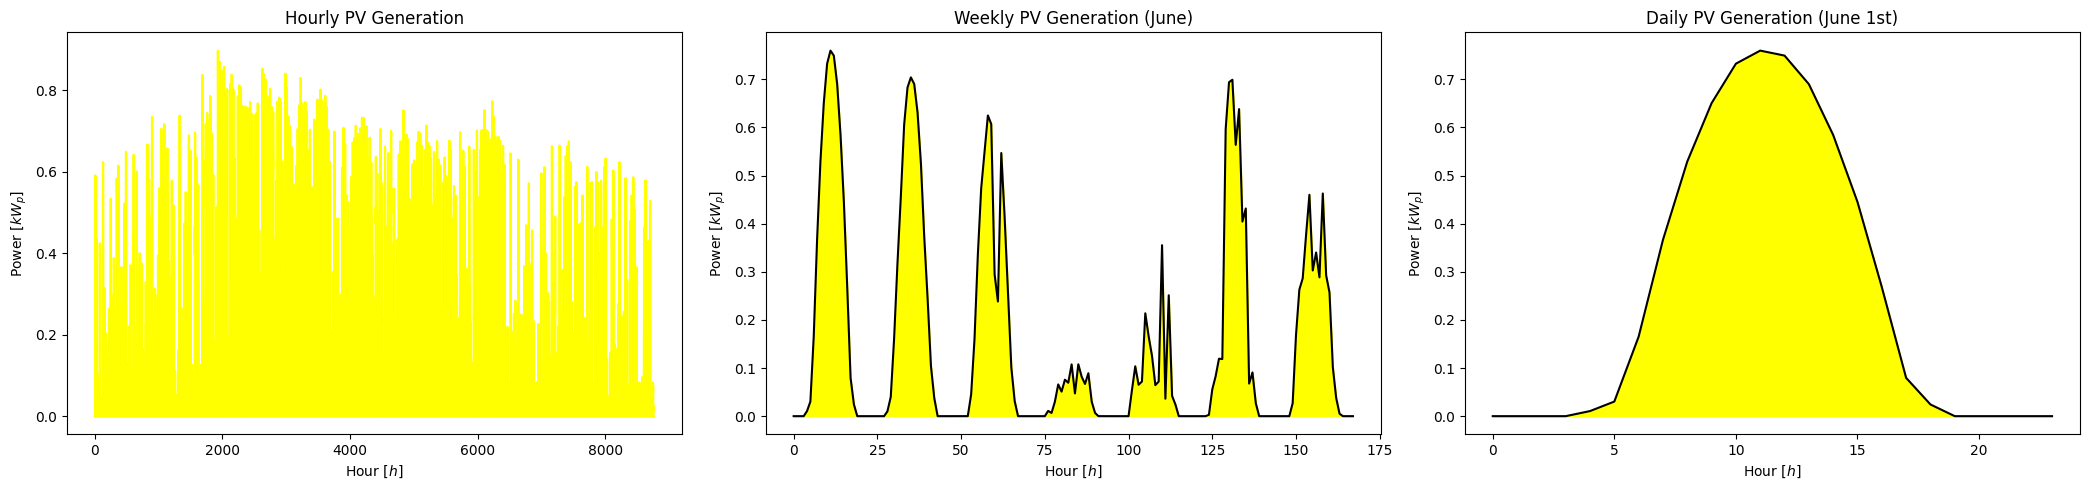

In [13]:
# Create subplots with three plots in one line
fig, axs = plt.subplots(1, 3, figsize=(21, 5))

# Plot 1: Hourly data for one year
axs[0].plot(P_values, color='yellow')
axs[0].fill_between(np.arange(0, 8760), P_values, color='yellow')
axs[0].set_title('Hourly PV Generation')

# Plot 2: Weekly data for June
week_june_start_index = 24 * (31 + 28 + 31 + 30 + 31) # Index of the first hour of June 1st
week_june_end_index = week_june_start_index + 24 * 7 # Index of the last hour of June 7th
axs[1].plot(P_values[week_june_start_index:week_june_end_index], color='black')
axs[1].fill_between(np.arange(0, 168), P_values[week_june_start_index:week_june_end_index], color='yellow')
axs[1].set_title('Weekly PV Generation (June)')

# Plot 3: Daily data for a specific day in June
day_june_index = week_june_start_index # Index of the first hour of June 1st
axs[2].plot(P_values[day_june_index:day_june_index + 24], color='black')
axs[2].fill_between(np.arange(0, 24), P_values[day_june_index:day_june_index + 24], color='yellow')
axs[2].set_title('Daily PV Generation (June 1st)')

for i in range(3):
    axs[i].set_xlabel('Hour [$h$]')
    axs[i].set_ylabel('Power [$kW_p$]')

plt.tight_layout()
plt.show()

For the sizing of the pv system, we have observed in the beginning, that the heating demand is much higher for the winter, than for the summer period. For a comparision, we would like to compare plots for each month between the potential infeed from our pv system and the heat demand, this time give as normalized values. This will give us an indication of how much pv installation is needed to have sufficient solar power throughout the year.

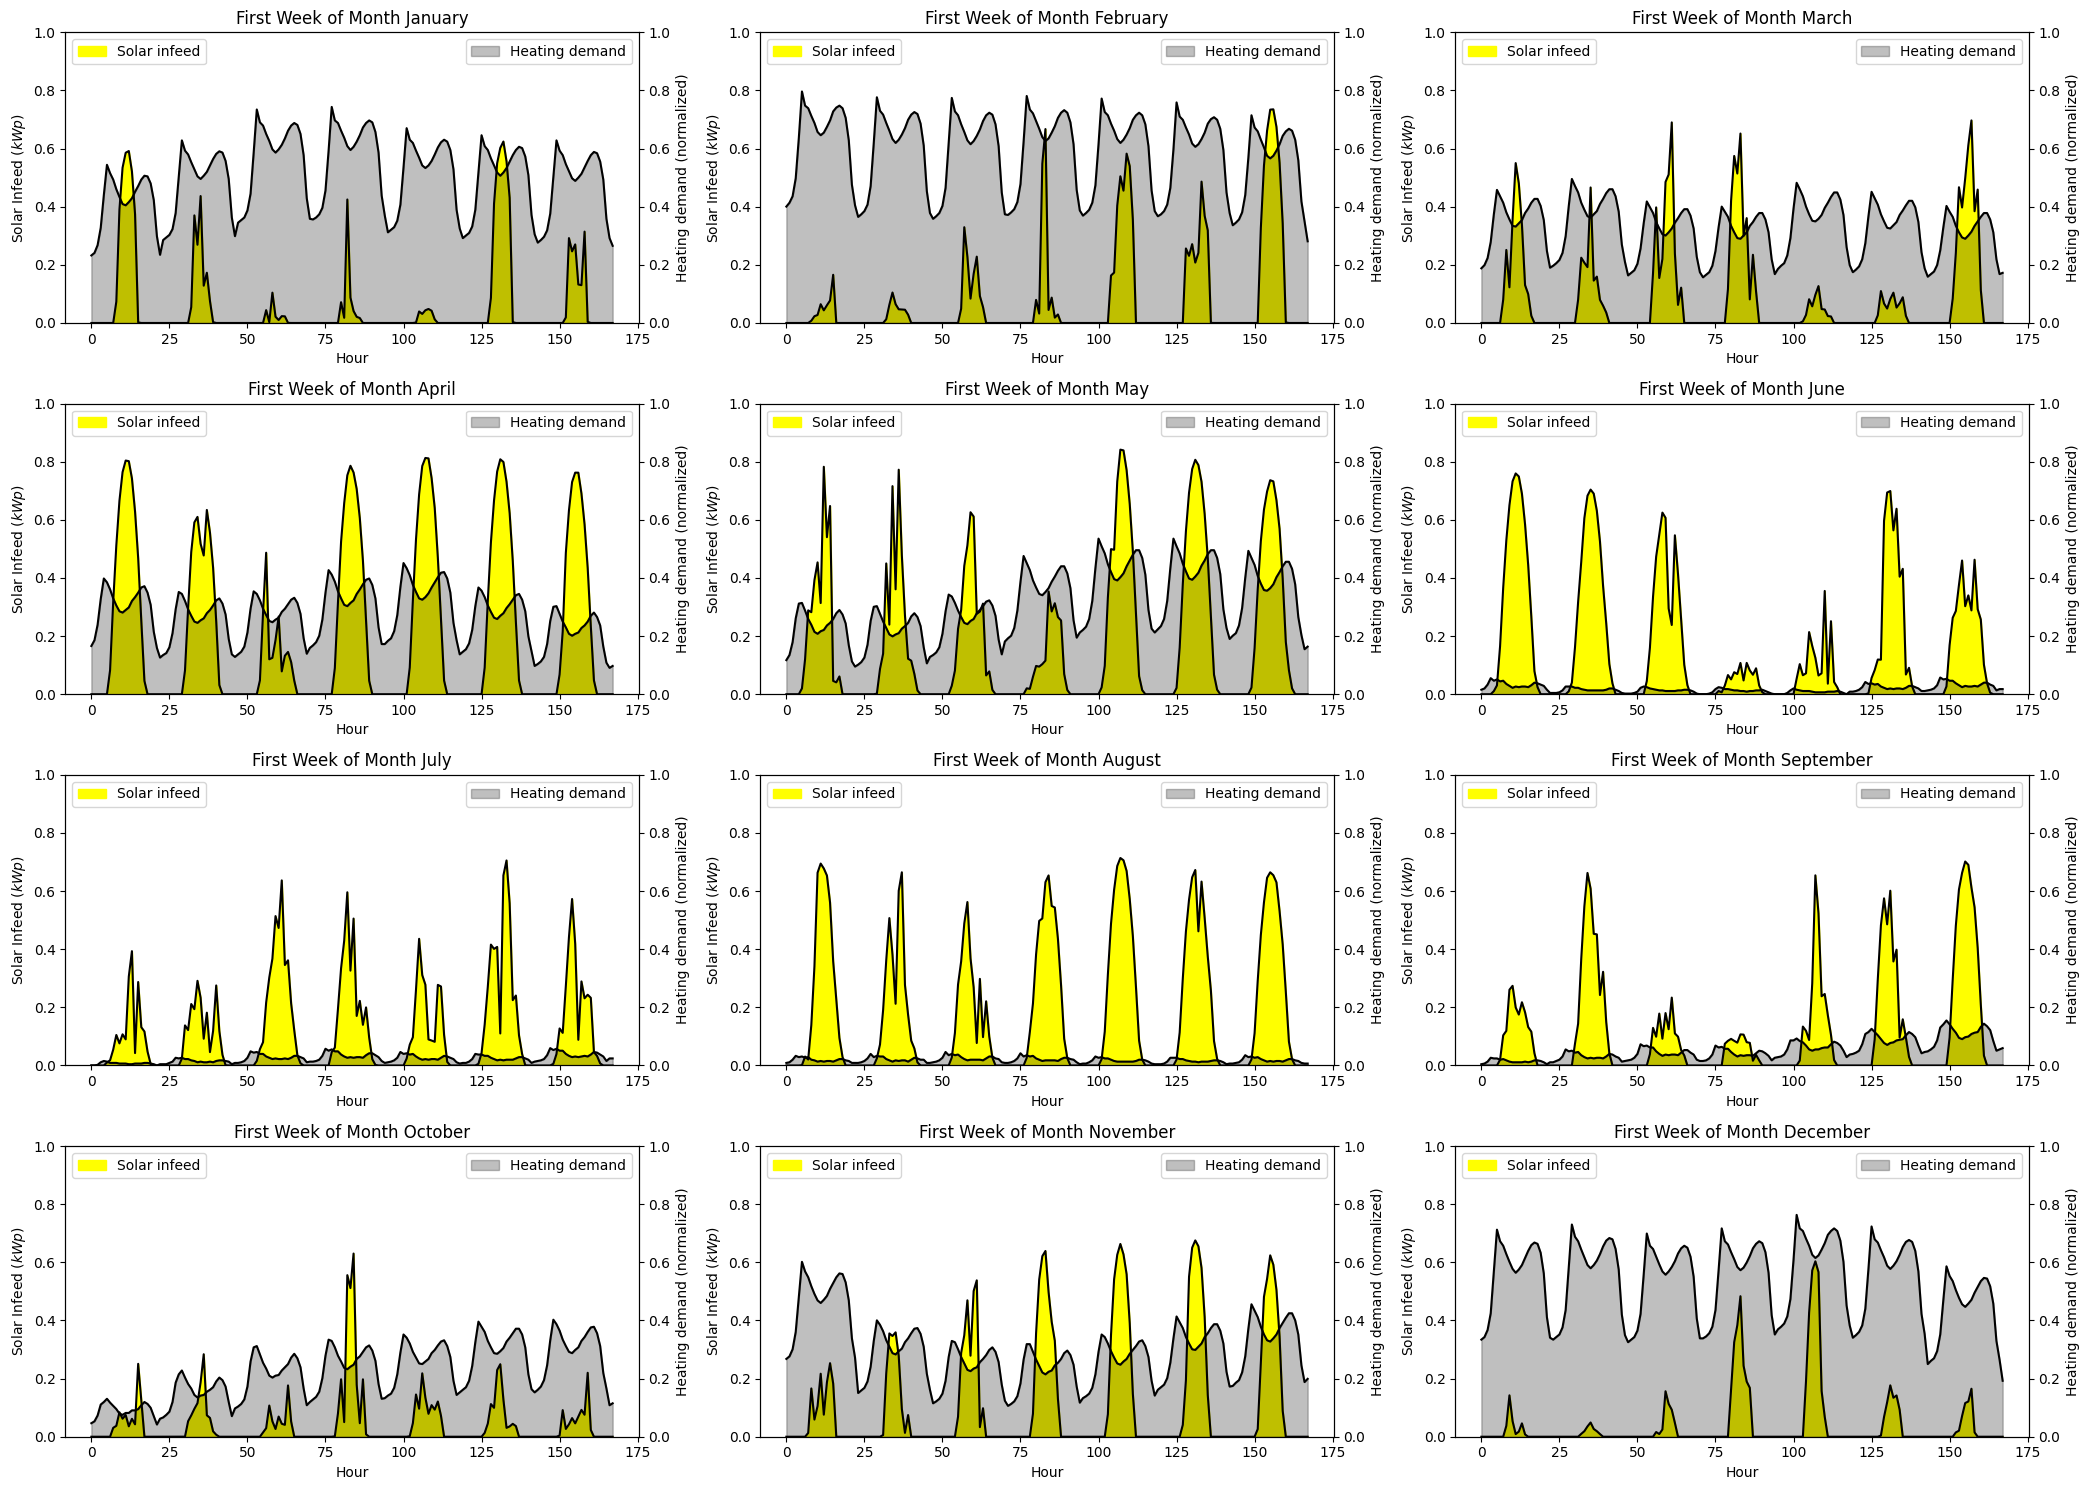

In [14]:
month_dict = {"January": 31, "February": 28, "March": 31, "April": 30, "May": 31, "June": 30, "July": 31, "August": 31, "September": 30, "October": 31, "November": 30, "December": 31}

# Extract the values as a list
number_of_days_days = list(month_dict.values())  
cumsum_days_of_month = np.cumsum(number_of_days_days)

fig, axs = plt.subplots(4, 3, figsize=(21, 15))

for i in range(12):  # Iterate over each month
    
    # Calculate the starting and ending indices for the first week of the month
    if i == 0:
        start_index=0
    else:
        start_index = 24 * cumsum_days_of_month[i-1]
    end_index = start_index + 24 * 7
    
    # Calculate the row and column indices in the subplot grid
    row = i // 3
    col = i % 3
    
    ax1 = axs[row, col]
    
    # Plot the first week of the month in the corresponding subplot
    ax1.plot(P_values[start_index:end_index], color='black')
    ax1.fill_between(np.arange(0, 168), P_values[start_index:end_index], color='yellow', label="Solar infeed")
    ax1.set_title(f"First Week of Month {list(month_dict.keys())[i]}")
    ax1.set_xlabel('Hour')
    ax1.set_ylabel('Solar Infeed ($kWp$)')
    ax1.set_ylim(0, 1)
    
    # Create a twin Axes object for the second y-axis
    ax2 = ax1.twinx()
    ax2.plot(norm_heating_demand_de[start_index:end_index], color='black')
    ax2.fill_between(np.arange(0, 168), norm_heating_demand_de[start_index:end_index], color='black', alpha=0.25, label="Heating demand")
    ax2.set_ylabel('Heating demand (normalized)')
    ax2.set_ylim(0, 1)  # Adjust the limits as needed
    
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
plt.tight_layout()
plt.show()

### Task 3.3 : Energy system analysis <a class="anchor" id="#task-3--interpretation"></a>
**Task description**: What do you think, could the pv system power the heat pump throughout the year? What is needed if not?

_Your answer goes here_

___
## C) Economic expansion optimization
For the economic evaluation of the expansion of the building energy system with a PV system, the formulation of an optimization problem is useful. The structure of the optimization problem is generally in the form:

\begin{aligned}
& \underset{x}{\text{minimize}}
& & f(x) \\
& \text{subject to}
& & g_i(x) = 0, \quad \text{for } i \in \{1, 2, \ldots, m\} \\
&&& h_j(x) \leq 0, \quad \text{for } j \in \{1, 2, \ldots, n\} \\
\end{aligned}


where $\vec{x} = [x_1, x_2, ..., x_k]^T$ is the vector of decision variables, and $f(x)$, $g_i(x)$, and $h_j(x)$ are functions that depend on the decision variables.

The objective of the optimization problem is to minimize the objective function $f(x)$ subject to the constraints $g_i(x) = 0$ and $h_j(x) <= 0$. The equality constraints $g_i(x) = 0$ represent relationships that must be satisfied exactly, while the inequality constraints $h_j(x) <= 0$ represent limitations or bounds on the decision variables.

This general form can be used to express a wide variety of optimization problems, including linear programming, quadratic programming, and nonlinear programming problems.

## Building energy optimisation
The objective function consists of cost terms that are related to the expansion and operation of the building energy system. The main parameters for the economic evaluation are listed in the tables below:

#### Economic parameters of the PV system

<center>

Specification | Index | Unit | Value
--- | --- | --- | ---
Installation costs | $c_{PV}^{tech}$ | [€] | 1000
Fixed costs | $c_{PV}^{fix,asset}$ | [€] | 300
Variable costs | $c_{PV}^{var,asset}$ | [€/$kW_p$] | 1400
Expected lifetime | T | [a] | 20

</center>

#### General economic parameters

<center>

Specification | Index | Unit | Value
--- | --- | --- | ---
Electricity costs (tariff) | $c_{el}^{fuel}$ | [€/$kWh$] | 0.31
Feed-in tariff | $r_{PV}^{FIT}$ | [€/$kWh$] | 0.09
Taxes on self-consumption | $c_{PV}^{self-con}$ | [€/$kWh$] | 0.03
Internal rate of return | i | [%] | 5

</center>

In [15]:
params = {
    "c_inst" : 500,
    "c_fix" : 300,
    "c_var" : 400,
    "lifetime" : 20,
    "c_elec" : 0.31,
    "c_fit" : 0.09,
    "c_self" : 0.03,
    "interest_rate" : 0.05
}

### Task 3.4 : Analyze the objective function <a class="anchor" id="#task-39--analyse-objective-function"></a>

**Task description:** Describe the economic objective of the optimization task.

_Your answer goes here_

### Task 3.5 : Analyze the associated decisions <a class="anchor" id="#task-310--analyse-deciscions"></a>

**Task description:** What kind of decisions are associated with the mentioned optimization problem?

_Your answer goes here_

### Task 3.6 : Analyze the resulting optimization problem <a class="anchor" id="#task-310--analyse-deciscions"></a>

**Task description:** What kind of optimization problem results from the properties of cost assumptions and the decisions?

_Your answer goes here_

Now, it is time to formulate the optimization problem and solve it. We will formulate the problem using GLPK, an open-source solver, that is reasonable fast to solve our problem (MILP). We will set up the optimization problem using ([Pyomo](https://pyomo.readthedocs.io/en/stable/index.html)). Please look at the first example from the following tutorial for [Mathematical Optimization](https://mobook.github.io/MO-book/notebooks/01/01.00.html).

In [16]:
import pyomo.environ as pyo

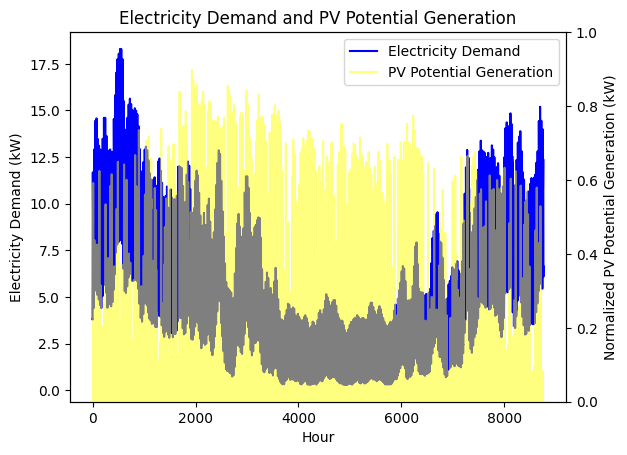

In [17]:
# Define the problem data
# Generate electricity demand profile
electricity_demand = df.sum(axis=1).to_numpy()

pv_potential_generation = P_values # in kW

fig, ax1 = plt.subplots()

# Plotting electricity_demand on the primary y-axis in blue
ax1.plot(electricity_demand, color='blue', label='Electricity Demand')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Electricity Demand (kW)')

# Creating a secondary y-axis
ax2 = ax1.twinx()

# Plotting pv_potential_generation on the secondary y-axis in yellow
ax2.plot(pv_potential_generation, color='yellow', alpha=0.5, label='PV Potential Generation')
ax2.set_ylabel('Normalized PV Potential Generation (kW)')
ax2.set_ylim(0,1)

# Adding title and legend
plt.title('Electricity Demand and PV Potential Generation')
lines = ax1.get_lines() + ax2.get_lines()
ax1.legend(lines, [line.get_label() for line in lines])

# Displaying the plot
plt.show()


## Task 3.7 : Add variables to model
**Task description:** Formulate the relevant variables for the model using gurobipy.

$$ min \ z = min \ TOTEX(ANN) = min \ CAPEX(ANN) \cdot \vec{x} + OPEX(ANN) \cdot \vec{y} $$

In [18]:

model = pyo.ConcreteModel("Solar PV Installation")

# Define the decision variables
model.x_pv_fix = pyo.Var(domain=pyo.Binary, name="pv_if_installed")
model.x_pv_dim = pyo.Var(domain=pyo.NonNegativeReals, name="pv_kw_installed")

model.t = pyo.RangeSet(0, len(electricity_demand)-1)

For the operation of the pv system, we would need to model the operation via additional constraints. Check where the arrows are pointed and try to use reasonable bounds.

![energy_flow](../../datasets/mes/exercise_3/figures/energy_flow_diagram.png "Energy Flow Diagram")

**Task description:** Add variables for the operation.

In [19]:
model.el_from_grid = pyo.Var(model.t, domain=pyo.NonNegativeReals, name="electricity_from_grid")
model.el_to_grid = pyo.Var(model.t, domain=pyo.NonNegativeReals, name="electricity_to_grid")
model.el_from_pv = pyo.Var(model.t, domain=pyo.NonNegativeReals, name="electricity_from_pv")

## Task 3.8
**Task description:** Formulate the dependency of the binary expansion decision and the discrete expansion decision of the PV system. Assume that a maximum roof area of 20 $m^2$ can be occupied.

In [20]:
pv_max = 20

@model.Constraint()
def pv_capacity_constraint(model):
    return model.x_pv_dim <= model.x_pv_fix * pv_max

## Task 3.9
**Task description:** Formulate the input-output restrictions for the PV system.

In [21]:
@model.Constraint(model.t)
def pv_generation_constraint(model, t):
    return model.el_from_pv[t] <= model.x_pv_dim * pv_potential_generation[t]

## Task 3.10
**Task description:** Formulate the energy flow balance for the electricity demand (Load coverage constraint).

In [22]:
@model.Constraint(model.t)
def electricity_balance_constraint(model, t):
    return model.el_from_grid[t] == electricity_demand[t] - model.el_from_pv[t]

In [23]:
@model.Constraint(model.t)
def pv_potential_generation(model, t):
    return model.el_to_grid[t] + model.el_from_pv[t] == pv_potential_generation[t]  * model.x_pv_dim

## Task 3.11 : Introduce maximum self-consumption
For a realistic illustration, it is assumed that the degree of self-consumption of the PV electricity is limited to 30% of the load per time interval. 

**Task description:** Formulate the constraint for these conditions.

In [24]:
@model.Constraint()
def maximum_self_consumption_constraint(model):
    return pyo.quicksum(model.el_from_pv[t] for t in model.t)  <= sum(electricity_demand) * 0.3

## Task 3.12 : Calculate objective value
**Task description:** Calculate the objective function value without a PV system.

In [25]:
from utils import present_value_factor

pvf = present_value_factor(params["lifetime"], params["interest_rate"])

# Objective functions

# Define the objective function
model.CAPEX = model.x_pv_fix * (params["c_inst"] + params["c_fix"]) / pvf + model.x_pv_dim * params["c_var"]
model.OPEX = pyo.quicksum((model.el_from_grid[t] * params["c_elec"] - model.el_to_grid[t] * params["c_fit"]+ model.el_from_pv[t] * params["c_self"]) for t in model.t)

            
model.objective = pyo.Objective(expr=model.CAPEX + model.OPEX, sense=pyo.minimize)

In [26]:
model

## Task 3.13 : Solve the model

**Task description:** Solve the model and return the dimension of the pv system.

In [27]:
from pyomo.environ import SolverFactory
solver = SolverFactory('glpk')
results = solver.solve(model, tee=True)  # 'tee=True' will display the solver output

# Check if solution was successful
from pyomo.opt import SolverStatus, TerminationCondition

if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
    print("Solver found an optimal solution!")
    # Accessing variable results
    print("Installed kW of PV:", pyo.value(model.x_pv_dim))
    print("PV Installed (Yes=1/No=0):", pyo.value(model.x_pv_fix))
    # for t in model.t:
    #    print(f"Electricity from grid at time {t}: {pyo.value(model.el_from_grid[t])}")
else:
    print("No optimal solution found. Status:", results.solver.status)


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmp5wvxg06h.glpk.raw --wglp /tmp/tmp2khuwphs.glpk.glp --cpxlp
 /tmp/tmpobfef_fn.pyomo.lp
Reading problem data from '/tmp/tmpobfef_fn.pyomo.lp'...
/tmp/tmpobfef_fn.pyomo.lp:192300: warning: lower bound of variable 'x2' redefined
/tmp/tmpobfef_fn.pyomo.lp:192300: warning: upper bound of variable 'x2' redefined
26282 rows, 26282 columns, 60880 non-zeros
One variable is binary
192301 lines were read
Writing problem data to '/tmp/tmp2khuwphs.glpk.glp'...
183532 lines were written
GLPK Integer Optimizer 5.0
26282 rows, 26282 columns, 60880 non-zeros
1 integer variable,  which is binary
Preprocessing...
8319 rows, 4161 columns, 16638 non-zeros
1 integer variable,  which is binary
Scaling...
 A: min|aij| =  3.000e-05  max|aij| =  2.000e+01  ratio =  6.667e+05
GM: min|aij| =  9.605e-01  max|aij| =  1.041e+00  ratio =  1.084e+00
EQ: min|aij| =  9.605e-01  max|aij| =  1.000e+00  ratio =  1.041e+00
2N: min|aij

As can be seen, there was no installation in a PV system, however, what happens if we double the prices for electricity.

In [28]:
params["c_elec"] *= 2
params

{'c_inst': 500,
 'c_fix': 300,
 'c_var': 400,
 'lifetime': 20,
 'c_elec': 0.62,
 'c_fit': 0.09,
 'c_self': 0.03,
 'interest_rate': 0.05}

In [29]:
# Define the objective function
model.CAPEX = model.x_pv_fix * (params["c_inst"] + params["c_fix"]) / pvf + model.x_pv_dim * params["c_var"]
model.OPEX = pyo.quicksum((model.el_from_grid[t] * params["c_elec"] - model.el_to_grid[t] * params["c_fit"]+ model.el_from_pv[t] * params["c_self"]) for t in model.t)

            
model.objective = pyo.Objective(expr=model.CAPEX + model.OPEX, sense=pyo.minimize)

results = solver.solve(model, tee=True)  # 'tee=True' will display the solver output

if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
    print("Solver found an optimal solution!")
    # Accessing variable results
    print("Installed kW of PV:", pyo.value(model.x_pv_dim))
    print("PV Installed (Yes=1/No=0):", pyo.value(model.x_pv_fix))
    # for t in model.t:
    #    print(f"Electricity from grid at time {t}: {pyo.value(model.el_from_grid[t])}")
else:
    print("No optimal solution found. Status:", results.solver.status)

'pyomo.core.base.objective.ScalarObjective'>) on block Solar PV Installation
with a new Component (type=<class
'pyomo.core.base.objective.ScalarObjective'>). This is usually indicative of a
modelling error. To avoid this warning, use block.del_component() and
block.add_component().
GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmpa31ls5kv.glpk.raw --wglp /tmp/tmpx51vn6l7.glpk.glp --cpxlp
 /tmp/tmp9mhiqszk.pyomo.lp
Reading problem data from '/tmp/tmp9mhiqszk.pyomo.lp'...
/tmp/tmp9mhiqszk.pyomo.lp:192300: warning: lower bound of variable 'x2' redefined
/tmp/tmp9mhiqszk.pyomo.lp:192300: warning: upper bound of variable 'x2' redefined
26282 rows, 26282 columns, 60880 non-zeros
One variable is binary
192301 lines were read
Writing problem data to '/tmp/tmpx51vn6l7.glpk.glp'...
183532 lines were written
GLPK Integer Optimizer 5.0
26282 rows, 26282 columns, 60880 non-zeros
1 integer variable,  which is binary
Preprocessing...
8319 rows, 4161 columns,